In [11]:
import sys; print('Python %s on %s' % (sys.version, sys.platform))
sys.path.extend(['C:\\Users\\troy\\Documents\\Code\\Libraries', 'C:\\Users\\troy\\Documents\\Excel Sheets', 'C:/Users/troy/Documents/Code/Libraries'])
from datetime import date, datetime, timedelta
import numpy as np
import pandas as pd
import ipywidgets as widgets
import matplotlib.pyplot as plt
import altair as alt
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

%load_ext autoreload
%autoreload 2
%matplotlib qt

from FinAPI.MacroData import Inflation as cpi_api
import FinAPI.DataAnalysis.EconomicTimeSeriesRegression as ecoanalysis_api
import pandas as pd
import numpy as np
from sklearn.linear_model import ARDRegression
import statsmodels.graphics.tsaplots


Python 3.7.6 (default, Jan  8 2020, 20:23:39) [MSC v.1916 64 bit (AMD64)] on win32
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### DataSet for Sticky and Non-Sticky CPI

In [3]:
dataset = cpi_api.DataSet.atlanta_sticky_flex_tickers

df = cpi_api.load_historical_data_dict(dataset)

headline_yoy_subsets = ['FlexibleCPI', 'StickyCPI']
headline_mom_subsets = ['FlexibleCPI1M', 'StickyCPI1M']

core_noncore_yoy_subsets = ['CoreFlexibleCPI', 'CoreStickyCPI', 'FlexibleCPI', 'StickyCPI']
core_noncore_mom_subsets = ['CoreFlexibleCPI1M', 'CoreStickyCPI1M', 'FlexibleCPI1M', 'StickyCPI1M']

sticky_core_shelter_yoy_subsets =  ['StickyCPI', 'CoreStickyCPI', 'StickyCPIexclShelter', 'CoreStickyCPIexlShelter']
sticky_core_shelter_mom_subsets = ['StickyCPI1M', 'CoreStickyCPI1M', 'StickyCPIexclShelter1M', 'CoreStickyCPIexlShelter1M']

#### Exploring the Sticky and Flexible CPI 

In [9]:
chart = alt.Chart(df[headline_yoy_subsets].reset_index()
        ).transform_fold(headline_yoy_subsets, as_=["CPI", "Value"]
        ).mark_line(
        ).encode(
            x='date:T',
            y='Value:Q',
            color='CPI:N',
            tooltip=['CPI:N', 'Value:Q']
        ).interactive()

chart

alt.Chart(...)

In [12]:
chart = alt.Chart(df[core_noncore_yoy_subsets].reset_index()
        ).transform_fold(core_noncore_yoy_subsets, as_=["CPI", "Value"]
        ).mark_line(
        ).encode(
            x='date:T',
            y='Value:Q',
            color='CPI:N',
            tooltip=['CPI:N', 'Value:Q', 'date:T']
        ).interactive()

chart

alt.Chart(...)

In [16]:
chart1 = alt.Chart(df[sticky_core_shelter_yoy_subsets].reset_index()
        ).transform_fold(['StickyCPI','StickyCPIexclShelter'], as_=["CPI", "Value"]
        ).mark_line(
        ).encode(
            x='date:T',
            y='Value:Q',
            color='CPI:N',
            tooltip=['CPI:N', 'Value:Q', 'date:T']
        ).interactive()

chart2 = alt.Chart(df[sticky_core_shelter_yoy_subsets].reset_index()
        ).transform_fold(['CoreStickyCPI', 'CoreStickyCPIexlShelter'], as_=["CPI", "Value"]
        ).mark_line(
        ).encode(
            x='date:T',
            y='Value:Q',
            color='CPI:N',
            tooltip=['CPI:N', 'Value:Q', 'date:T']
        ).interactive()

chart1 | chart2

alt.HConcatChart(...)

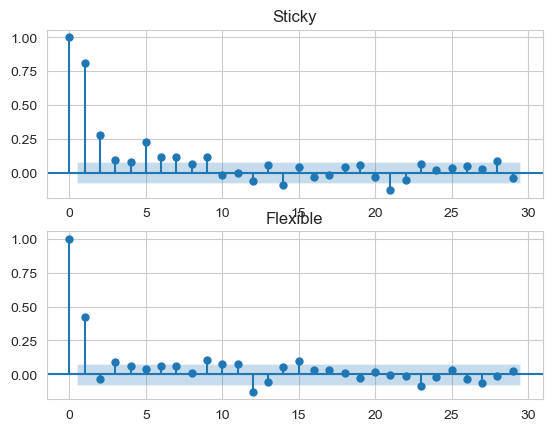

In [26]:
ax1 = plt.subplot(211)
plot_pacf(df['StickyCPI1M'], ax=ax1, title='Sticky')
ax2 = plt.subplot(212)
plot_pacf(df['FlexibleCPI1M'], ax=ax2, title='Flexible')

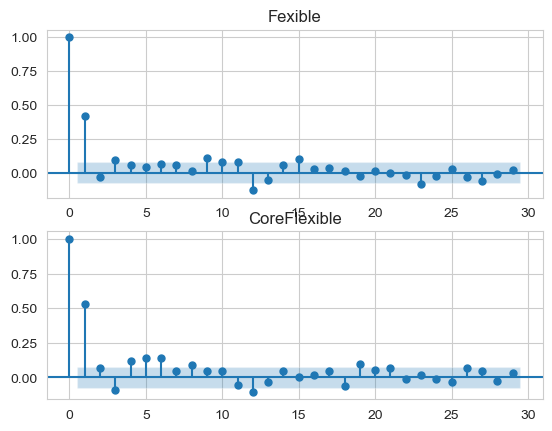

In [30]:
ax1 = plt.subplot(211)
plot_pacf(df['FlexibleCPI1M'], ax=ax1, title='Fexible')
ax2 = plt.subplot(212)
plot_pacf(df['CoreFlexibleCPI1M'], ax=ax2, title='CoreFlexible')

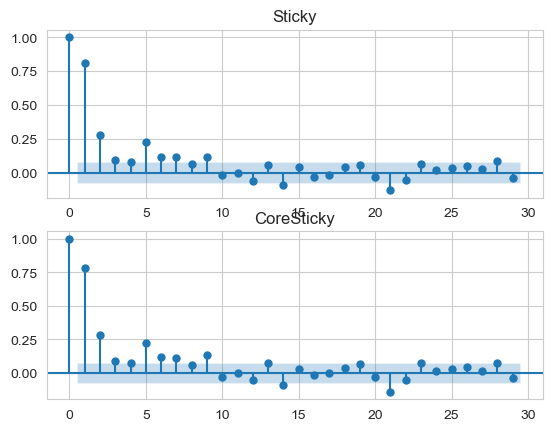

In [31]:
ax1 = plt.subplot(211)
plot_pacf(df['StickyCPI1M'], ax=ax1, title='Sticky')
ax2 = plt.subplot(212)
plot_pacf(df['CoreStickyCPI1M'], ax=ax2, title='CoreSticky')

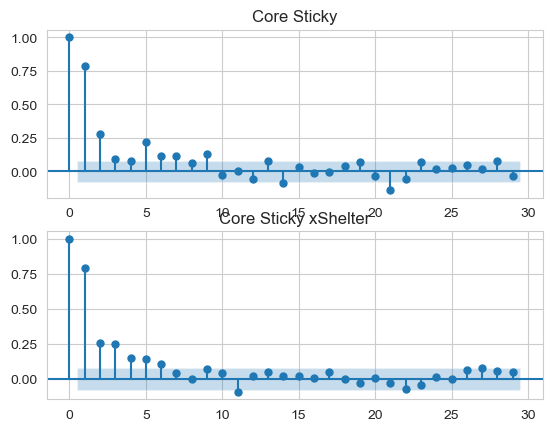

In [34]:
ax1 = plt.subplot(211)
plot_pacf(df['CoreStickyCPI1M'], ax=ax1, title='Core Sticky')
ax2 = plt.subplot(212)
plot_pacf(df['CoreStickyCPIexlShelter1M'], ax=ax2, title='Core Sticky xShelter')

### DataSet for CPI categories

In [5]:
data_sets = ['cpi_index', 'cpi_categories', 'cpi_energy_index', 'cpi_energy_goods', 'cpi_energy_services', 'cpi_food_index', 'cpi_good_serv_indexes',
             'cpi_good_dur_nondur', 'cpi_good_index', 'cpi_services_index']

nsa_datasets = dict()
sa_datasets = dict()
static_df = cpi_api.load_static()

for key in data_sets:
    try:
        nsa_datasets[key] = cpi_api.load_historical_data_dict(cpi_api.DataSet.get_dataset(key))
        sa_datasets[key] = cpi_api.load_seasonal_history_for_dict(cpi_api.DataSet.get_dataset(key), static_df)
        print(key)
    except:
        print(key, "- error")


cpi_index
cpi_categories
cpi_energy_index
cpi_energy_goods
cpi_energy_services
cpi_food_index
cpi_good_serv_indexes
cpi_good_dur_nondur
cpi_good_index
cpi_services_index - error


In [45]:
yoy_categories = (sa_datasets['cpi_categories'].pct_change(12) * 100)

chart1 = alt.Chart(yoy_categories.reset_index()
        ).transform_fold(yoy_categories.columns.values
        ).mark_line(
        ).encode(
            x='date:T',
            y='value:Q',
            color='key:N',
            tooltip=['key:N', 'value:Q', 'date:T']
        ).interactive()

chart1

alt.Chart(...)

#### Estimating the loading of Sticky and Flexible on the individual components

In [33]:
categories = sa_datasets['cpi_categories'].pct_change() * 100

regressor = df[core_noncore_mom_subsets]
regressor = regressor.assign(FlexibleFECPI1M=regressor.FlexibleCPI1M - regressor.CoreFlexibleCPI1M)
regressor = regressor.assign(StickyFECPI1M=regressor.StickyCPI1M - regressor.CoreStickyCPI1M)
regressor = regressor[['CoreFlexibleCPI1M', 'CoreStickyCPI1M', 'FlexibleFECPI1M', 'StickyFECPI1M']] * 100

Y, X = categories.copy().align(regressor.copy(), join="inner", axis=0)
idx = Y.dropna().index.intersection(X.dropna().index)

# Y = categories.loc[Y['date'], :]
# regressor = regressor.loc[X, :]
split= -36
category = 'Housing'
endog = Y.loc[idx, category][:split]
endog_out = Y.loc[idx, category][split:]

exog = X.loc[idx, :].iloc[:split, :]
exog_out = X.loc[idx, :].iloc[split:, :]

np.any(np.isnan(endog)), np.any(np.isnan(exog))

(False, False)

In [32]:
X

,CoreFlexibleCPI1M,CoreStickyCPI1M,FlexibleFECPI1M,StickyFECPI1M
date,,,,
1970-01-31,0.12,0.72,-0.08,-0.03
1970-02-28,0.26,0.75,0.17,-0.01
1970-03-31,0.01,0.79,-0.20,-0.04
1970-04-30,0.34,0.50,0.18,0.05
1970-05-31,0.39,0.60,-0.08,0.00
...,...,...,...,...
2022-03-31,-0.62,0.48,4.04,-0.01
2022-04-30,0.31,0.58,-0.61,-0.01
2022-05-31,1.19,0.59,0.88,0.01


In [36]:
categories = sa_datasets['cpi_categories'].pct_change() * 100
split = 36

Y, X = ecoanalysis_api.DataModification.align_endog_exog(categories, regressor, intersect=True, dropna=True)
X_full = ecoanalysis_api.DataModification.add_lags_to_exog(X, 12)
X_full = ecoanalysis_api.DataModification.add_endog_lags_to_exog(X_full, Y, 12)
X_full = X_full.dropna()
Y_full = Y.loc[X_full.index, :]

endog, exog, endog_out, exog_out = ecoanalysis_api.DataModification.split_data(X, Y, 36)

In [40]:
regressor = X_full
regressand = Y_full

num_bootstraps=50
min_size=12
max_size=60
n_pop = regressand.shape[0]
category = 'Housing'


random_start_pts = np.random.randint(0, n_pop-min_size+1, num_bootstraps*10)
random_lengths = np.repeat(np.random.randint(min_size, max_size, 10), num_bootstraps)
samples_idx = zip(random_start_pts, random_lengths)

n_features = regressor.shape[1]
total_feature_participation = pd.Series(0, index=regressor.columns.values)
relevant_feature_count = pd.Series(0, index=regressor.columns.values)

for i, (start, length) in enumerate(samples_idx):
    X_subsample = regressor.iloc[start:start + length, : ]
    Y_subsample = regressand.iloc[start:start + length, :]
    for feat_iter in range(10):
        feature_set_size = np.random.randint(1, n_features)
        col_names = np.random.choice(regressor.columns.values, feature_set_size, replace=False)
        assert len(col_names) == feature_set_size
        X_regress = X_subsample.loc[:, col_names]
        ard = ARDRegression(compute_score=True, n_iter=30, fit_intercept=True).fit(X_regress, Y_subsample[category])
        coef_series = pd.Series(ard.coef_, col_names)
        coef_series = coef_series[coef_series!=0.]
        total_feature_participation[col_names] = total_feature_participation[col_names] + 1
        relevant_feature_count[coef_series.index] = relevant_feature_count[coef_series.index] + 1
    if i%10==0:
        print("%s / %s" % (i*10, num_bootstraps*10*10), end=" - ")


0 / 5000 - 100 / 5000 - 200 / 5000 - 300 / 5000 - 400 / 5000 - 500 / 5000 - 600 / 5000 - 700 / 5000 - 800 / 5000 - 900 / 5000 - 1000 / 5000 - 1100 / 5000 - 1200 / 5000 - 1300 / 5000 - 1400 / 5000 - 1500 / 5000 - 1600 / 5000 - 1700 / 5000 - 1800 / 5000 - 1900 / 5000 - 2000 / 5000 - 2100 / 5000 - 2200 / 5000 - 2300 / 5000 - 2400 / 5000 - 2500 / 5000 - 2600 / 5000 - 2700 / 5000 - 2800 / 5000 - 2900 / 5000 - 3000 / 5000 - 3100 / 5000 - 3200 / 5000 - 3300 / 5000 - 3400 / 5000 - 3500 / 5000 - 3600 / 5000 - 3700 / 5000 - 3800 / 5000 - 3900 / 5000 - 4000 / 5000 - 4100 / 5000 - 4200 / 5000 - 4300 / 5000 - 4400 / 5000 - 4500 / 5000 - 4600 / 5000 - 4700 / 5000 - 4800 / 5000 - 4900 / 5000 - 

In [44]:
imp_features = (relevant_feature_count / total_feature_participation).sort_values(ascending=False)
feature_corr = X_full.corr()

In [79]:


ard = ARDRegression(compute_score=True, n_iter=30, fit_intercept=True).fit(exog, endog)
coef_series = pd.Series(ard.coef_, exog.columns)

y_ard, y_ard_std = ard.predict(exog.values, return_std=True)
resid = endog.values - y_ard

data_df = pd.DataFrame(dict(dates=endog.index, 
                            energy_cpi=endog, 
                            fitted=pd.Series(y_ard, endog.index), 
                            resid=pd.Series(resid, endog.index)))

print("In sample Rsq of the model is - %s" % np.round(ard.score(y=endog.values, X=exog), 2))
print("Out Sample Rsq of the model is - %s" % np.round(ard.score(y=endog_out.values, X=exog_out), 2))
print("Coefs Selected ")
print(pd.Series(ard.coef_, exog.columns.values))

statsmodels.graphics.tsaplots.plot_pacf(resid)

line1 = alt.Chart(data_df).mark_line().encode(x='dates:T', y=alt.Y('energy_cpi', title="Energy CPI")).properties(width="container")
line2 = alt.Chart(data_df).mark_line(color='red').encode(x='dates:T', y=alt.Y('fitted')).properties(width="container")
line3 = alt.Chart(data_df).mark_line(color='red').encode(x='dates:T', y=alt.Y('resid')).properties(width="container")
line1 + line2 | line3

In sample Rsq of the model is - 0.27
Out Sample Rsq of the model is - 0.68
Coefs Selected 
CoreFlexibleCPI1M    0.108489
CoreStickyCPI1M      0.786338
FlexibleFECPI1M      0.054415
StickyFECPI1M        0.478246
dtype: float64


alt.HConcatChart(...)

#### RECONSTRUCTNG THE STICKY AND FLEXIBLE COMPONENTS